In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import pandas as pd

In [28]:
# Set parameters
IMG_WIDTH, IMG_HEIGHT = 48, 48
NUM_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 20 # Increased epochs
LEARNING_RATE = 0.001
EMOTION_CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTION_CLASSES)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# Create data generators with enhanced data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased rotation
    width_shift_range=0.2,  # Increased shift
    height_shift_range=0.2,  # Increased shift
    zoom_range=0.2,  # Increased zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Add brightness variation
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Print dataset information before loading
print("Loading datasets from directories...")

# Load datasets from directories
train_generator = train_datagen.flow_from_directory(
    'split_dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    'split_dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Loading datasets from directories...
Found 90477 images belonging to 7 classes.
Found 30159 images belonging to 7 classes.
Found 30159 images belonging to 7 classes.
Number of training samples: 90477
Number of validation samples: 30159
Number of test samples: 30159
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [30]:
# Build improved CNN model with BatchNormalization
def build_model():
    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS))
    
    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Added BatchNormalization
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Create and compile the model
model = build_model()
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,04

 Total params: 2,653,671 (10.12 MB)

 Trainable params: 2,651,751 (10.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [31]:
# Set up enhanced callbacks for model training
checkpoint = ModelCheckpoint(
    'models/emotion_cnn_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Add learning rate reducer callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Print training parameters
print(f"Training with batch size: {BATCH_SIZE}, epochs: {EPOCHS}, learning rate: {LEARNING_RATE}")
print(f"Steps per epoch: {len(train_generator)}, Validation steps: {len(validation_generator)}")

# Train the model with proper steps calculation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # This is the correct way to calculate steps
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # This is the correct way to calculate steps
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Save training history to CSV for later analysis
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

# Load the best model
best_model = load_model('models/emotion_cnn_best.h5')

Training with batch size: 64, epochs: 20, learning rate: 0.001
Steps per epoch: 1414, Validation steps: 472


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.2169 - loss: 2.1684
Epoch 1: val_accuracy improved from -inf to 0.31228, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 857s 602ms/step - accuracy: 0.2170 - loss: 2.1683 - val_accuracy: 0.3123 - val_loss: 1.7006 - learning_rate: 0.0010
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3082 - loss: 1.7362
Epoch 2: val_accuracy improved from 0.31228 to 0.42558, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 869s 615ms/step - accuracy: 0.3082 - loss: 1.7362 - val_accuracy: 0.4256 - val_loss: 1.4925 - learning_rate: 0.0010
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.3912 - loss: 1.5596
Epoch 3: val_accuracy improved from 0.42558 to 0.47216, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 860s 608ms/step - accuracy: 0.3912 - loss: 1.5596 - val_accuracy: 0.4722 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4428 - loss: 1.4540
Epoch 4: val_accuracy improved from 0.47216 to 0.51902, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 763s 540ms/step - accuracy: 0.4428 - loss: 1.4540 - val_accuracy: 0.5190 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.4669 - loss: 1.3878
Epoch 5: val_accuracy improved from 0.51902 to 0.53748, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 743s 525ms/step - accuracy: 0.4669 - loss: 1.3878 - val_accuracy: 0.5375 - val_loss: 1.2267 - learning_rate: 0.0010
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4901 - loss: 1.3434
Epoch 6: val_accuracy improved from 0.53748 to 0.55134, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 821s 581ms/step - accuracy: 0.4901 - loss: 1.3434 - val_accuracy: 0.5513 - val_loss: 1.1755 - learning_rate: 0.0010
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.4954 - loss: 1.3186
Epoch 7: val_accuracy improved from 0.55134 to 0.55652, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 745s 527ms/step - accuracy: 0.4954 - loss: 1.3186 - val_accuracy: 0.5565 - val_loss: 1.1713 - learning_rate: 0.0010
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.5095 - loss: 1.2906
Epoch 8: val_accuracy improved from 0.55652 to 0.56315, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 822s 581ms/step - accuracy: 0.5095 - loss: 1.2906 - val_accuracy: 0.5631 - val_loss: 1.1653 - learning_rate: 0.0010
Epoch 9/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.5151 - loss: 1.2745
Epoch 9: val_accuracy improved from 0.56315 to 0.57260, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 891s 630ms/step - accuracy: 0.5151 - loss: 1.2745 - val_accuracy: 0.5726 - val_loss: 1.1278 - learning_rate: 0.0010
Epoch 10/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5271 - loss: 1.2503
Epoch 10: val_accuracy improved from 0.57260 to 0.58132, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 745s 527ms/step - accuracy: 0.5271 - loss: 1.2503 - val_accuracy: 0.5813 - val_loss: 1.1006 - learning_rate: 0.0010
Epoch 11/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5297 - loss: 1.2402
Epoch 11: val_accuracy improved from 0.58132 to 0.59462, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 745s 527ms/step - accuracy: 0.5297 - loss: 1.2402 - val_accuracy: 0.5946 - val_loss: 1.0713 - learning_rate: 0.0010
Epoch 12/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.5335 - loss: 1.2284
Epoch 12: val_accuracy improved from 0.59462 to 0.60204, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 744s 526ms/step - accuracy: 0.5335 - loss: 1.2283 - val_accuracy: 0.6020 - val_loss: 1.0557 - learning_rate: 0.0010
Epoch 13/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5415 - loss: 1.2089
Epoch 13: val_accuracy did not improve from 0.60204
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 745s 527ms/step - accuracy: 0.5415 - loss: 1.2089 - val_accuracy: 0.5800 - val_loss: 1.1103 - learning_rate: 0.0010
Epoch 14/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.5489 - loss: 1.2005
Epoch 14: val_accuracy did not improve from 0.60204
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 826s 584ms/step - accuracy: 0.5489 - loss: 1.2005 - val_accuracy: 0.5954 - val_loss: 1.0656 - learning_rate: 0.0010
Epoch 15/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5504 - loss: 1.1917
Epoch 15: val_accuracy improved from 0.60204 to 0.60387, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 754s 533ms/step - accuracy: 0.5504 - loss: 1.1917 - val_accuracy: 0.6039 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 16/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5538 - loss: 1.1798
Epoch 16: val_accuracy did not improve from 0.60387
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 817s 578ms/step - accuracy: 0.5538 - loss: 1.1798 - val_accuracy: 0.6035 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 17/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5560 - loss: 1.1722
Epoch 17: val_accuracy improved from 0.60387 to 0.61945, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 827s 585ms/step - accuracy: 0.5560 - loss: 1.1722 - val_accuracy: 0.6195 - val_loss: 1.0125 - learning_rate: 0.0010
Epoch 18/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5643 - loss: 1.1581
Epoch 18: val_accuracy improved from 0.61945 to 0.62582, saving model to models/emotion_cnn_best.h5


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 743s 526ms/step - accuracy: 0.5643 - loss: 1.1581 - val_accuracy: 0.6258 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 19/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5637 - loss: 1.1528
Epoch 19: val_accuracy did not improve from 0.62582
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 781s 552ms/step - accuracy: 0.5637 - loss: 1.1528 - val_accuracy: 0.6230 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 20/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5715 - loss: 1.1414
Epoch 20: val_accuracy did not improve from 0.62582
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 829s 586ms/step - accuracy: 0.5715 - loss: 1.1414 - val_accuracy: 0.6253 - val_loss: 1.0059 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 18.


Evaluating model on test data...
472/472 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.5685 - loss: 1.1027
Test accuracy: 0.6212
Test loss: 1.0113
Generating predictions...
472/472 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.56      0.54      4186
     disgust       0.66      0.23      0.34       432
        fear       0.49      0.27      0.35      4071
       happy       0.84      0.87      0.85      7789
     neutral       0.57      0.60      0.59      5541
         sad       0.45      0.54      0.49      4698
    surprise       0.67      0.74      0.71      3442

    accuracy                           0.62     30159
   macro avg       0.60      0.54      0.55     30159
weighted avg       0.62      0.62      0.61     30159



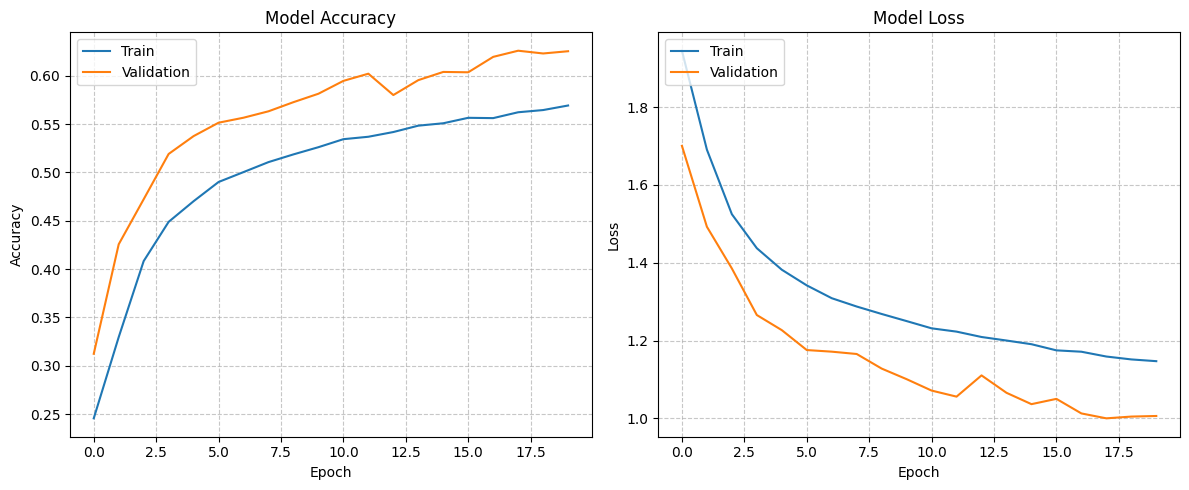

In [32]:
# Evaluate the model on test data
print("Evaluating model on test data...")
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions for the test set
print("Generating predictions...")
test_generator.reset()
y_pred_prob = best_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTION_CLASSES))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [33]:
# Show learning rate changes if available
if 'lr' in history.history:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('learning_rate.png')
    plt.show()

In [34]:
# Implement Grad-CAM visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, create a model that maps the input image to the activations of the last conv layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # This is the gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the channels by the computed importance and sum
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)
    
    return heatmap.numpy()

In [35]:
def display_gradcam(img_path, heatmap, alpha=0.6):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = superimposed_img / np.max(superimposed_img)
    superimposed_img = np.uint8(255 * superimposed_img)
    
    return superimposed_img

# Sample predictions with Grad-CAM visualization
def predict_with_gradcam(model, img_path):
    # Find the last convolutional layer automatically
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer_name = layer.name
            break
    
    if last_conv_layer_name is None:
        print("Could not find a convolutional layer in the model")
        return None
        
    print(f"Using layer {last_conv_layer_name} for Grad-CAM")
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img, axis=0) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_emotion = EMOTION_CLASSES[predicted_class]
    confidence = predictions[0][predicted_class]
    
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # Display the original image and the Grad-CAM
    superimposed_img = display_gradcam(img_path, heatmap)
    
    # Get true label from path
    true_emotion = os.path.basename(os.path.dirname(img_path))
    
    # Return results
    return {
        'image': img,
        'heatmap': heatmap,
        'superimposed_img': superimposed_img,
        'predicted': predicted_emotion,
        'actual': true_emotion,
        'confidence': confidence
    }

Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Sample 1: predicted: sad, actual: angry
Using layer conv2d_17 for Grad-CAM


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sample 2: predicted: disgust, actual: disgust
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample 3: predicted: sad, actual: fear
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 4: predicted: happy, actual: happy
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sample 5: predicted: sad, actual: neutral
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 6: predicted: sad, actual: sad
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sample 7: predicted: surprise, actual: surprise


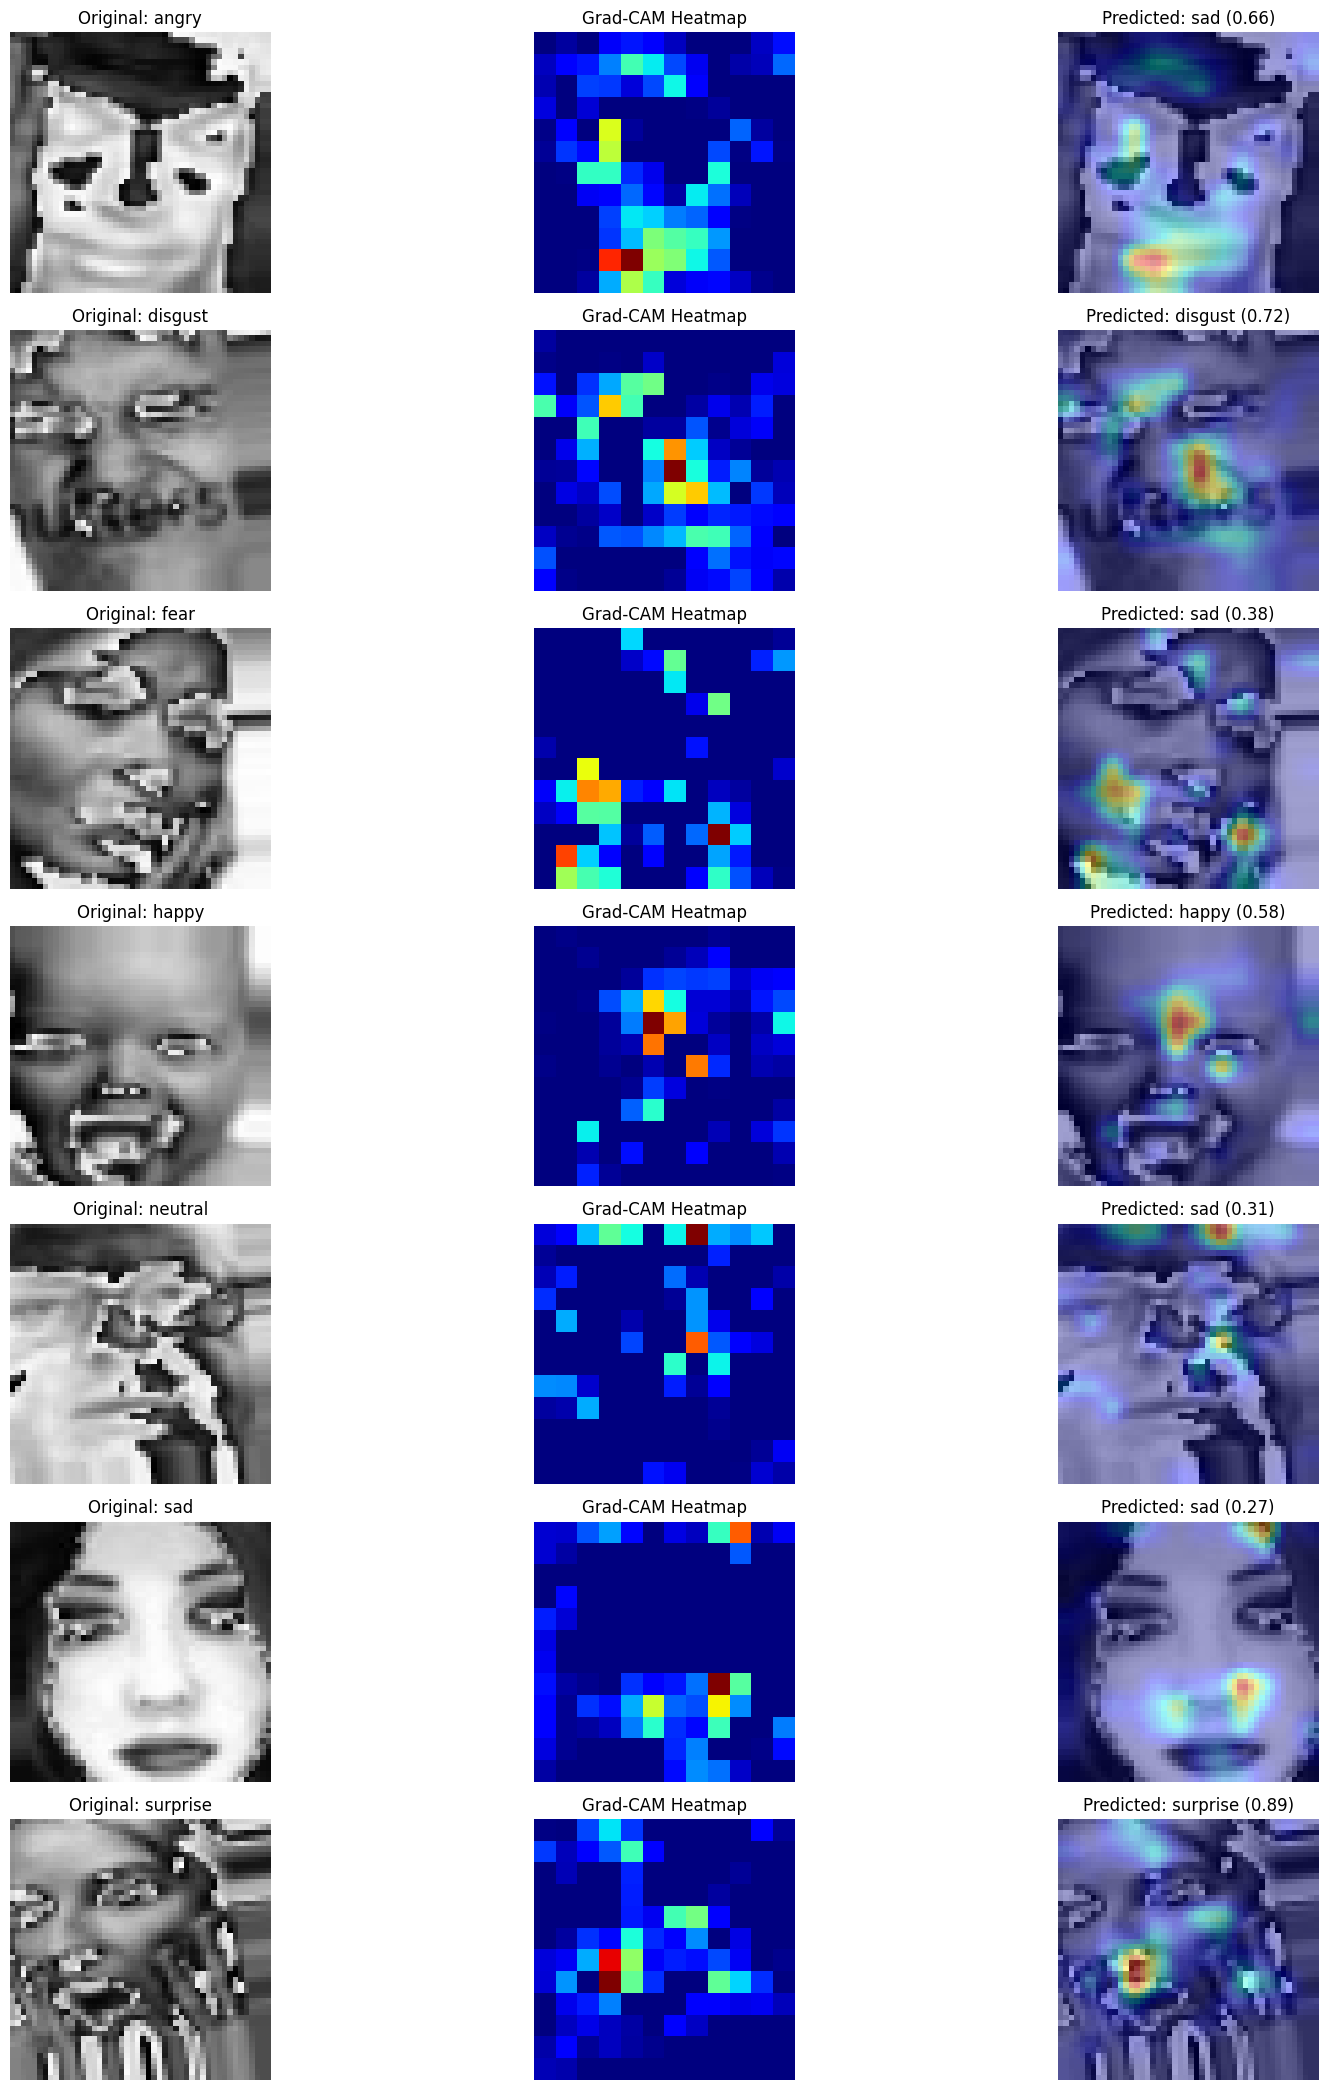

In [36]:
# Find a sample image from each class in the test set
sample_images = []
for emotion in EMOTION_CLASSES:
    emotion_dir = os.path.join('split_dataset/test', emotion)
    if os.path.exists(emotion_dir):
        image_files = os.listdir(emotion_dir)
        if image_files:
            sample_images.append(os.path.join(emotion_dir, image_files[0]))

# Make predictions on sample images
plt.figure(figsize=(18, len(sample_images) * 3))

for i, img_path in enumerate(sample_images):
    if os.path.exists(img_path):
        result = predict_with_gradcam(best_model, img_path)
        if result:
            plt.subplot(len(sample_images), 3, i*3 + 1)
            plt.imshow(result['image'], cmap='gray')
            plt.title(f"Original: {result['actual']}")
            plt.axis('off')
            
            plt.subplot(len(sample_images), 3, i*3 + 2)
            plt.imshow(result['heatmap'], cmap='jet')
            plt.title("Grad-CAM Heatmap")
            plt.axis('off')
            
            plt.subplot(len(sample_images), 3, i*3 + 3)
            plt.imshow(result['superimposed_img'])
            plt.title(f"Predicted: {result['predicted']} ({result['confidence']:.2f})")
            plt.axis('off')
            
            print(f"Sample {i+1}: predicted: {result['predicted']}, actual: {result['actual']}")

plt.tight_layout()
plt.savefig('gradcam_visualization.png')
plt.show()

Generating enhanced prediction visualizations...
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sample 1: predicted: sad, actual: angry
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sample 2: predicted: disgust, actual: disgust
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 3: predicted: sad, actual: fear
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sample 4: predicted: happy, actual: happy
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Sample 5: predicted: sad, actual: neutral
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sample 6: predicted: sad, actual: sad
Using layer conv2d_17 for Grad-CAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sample 7: predicted: surprise, actual: surprise


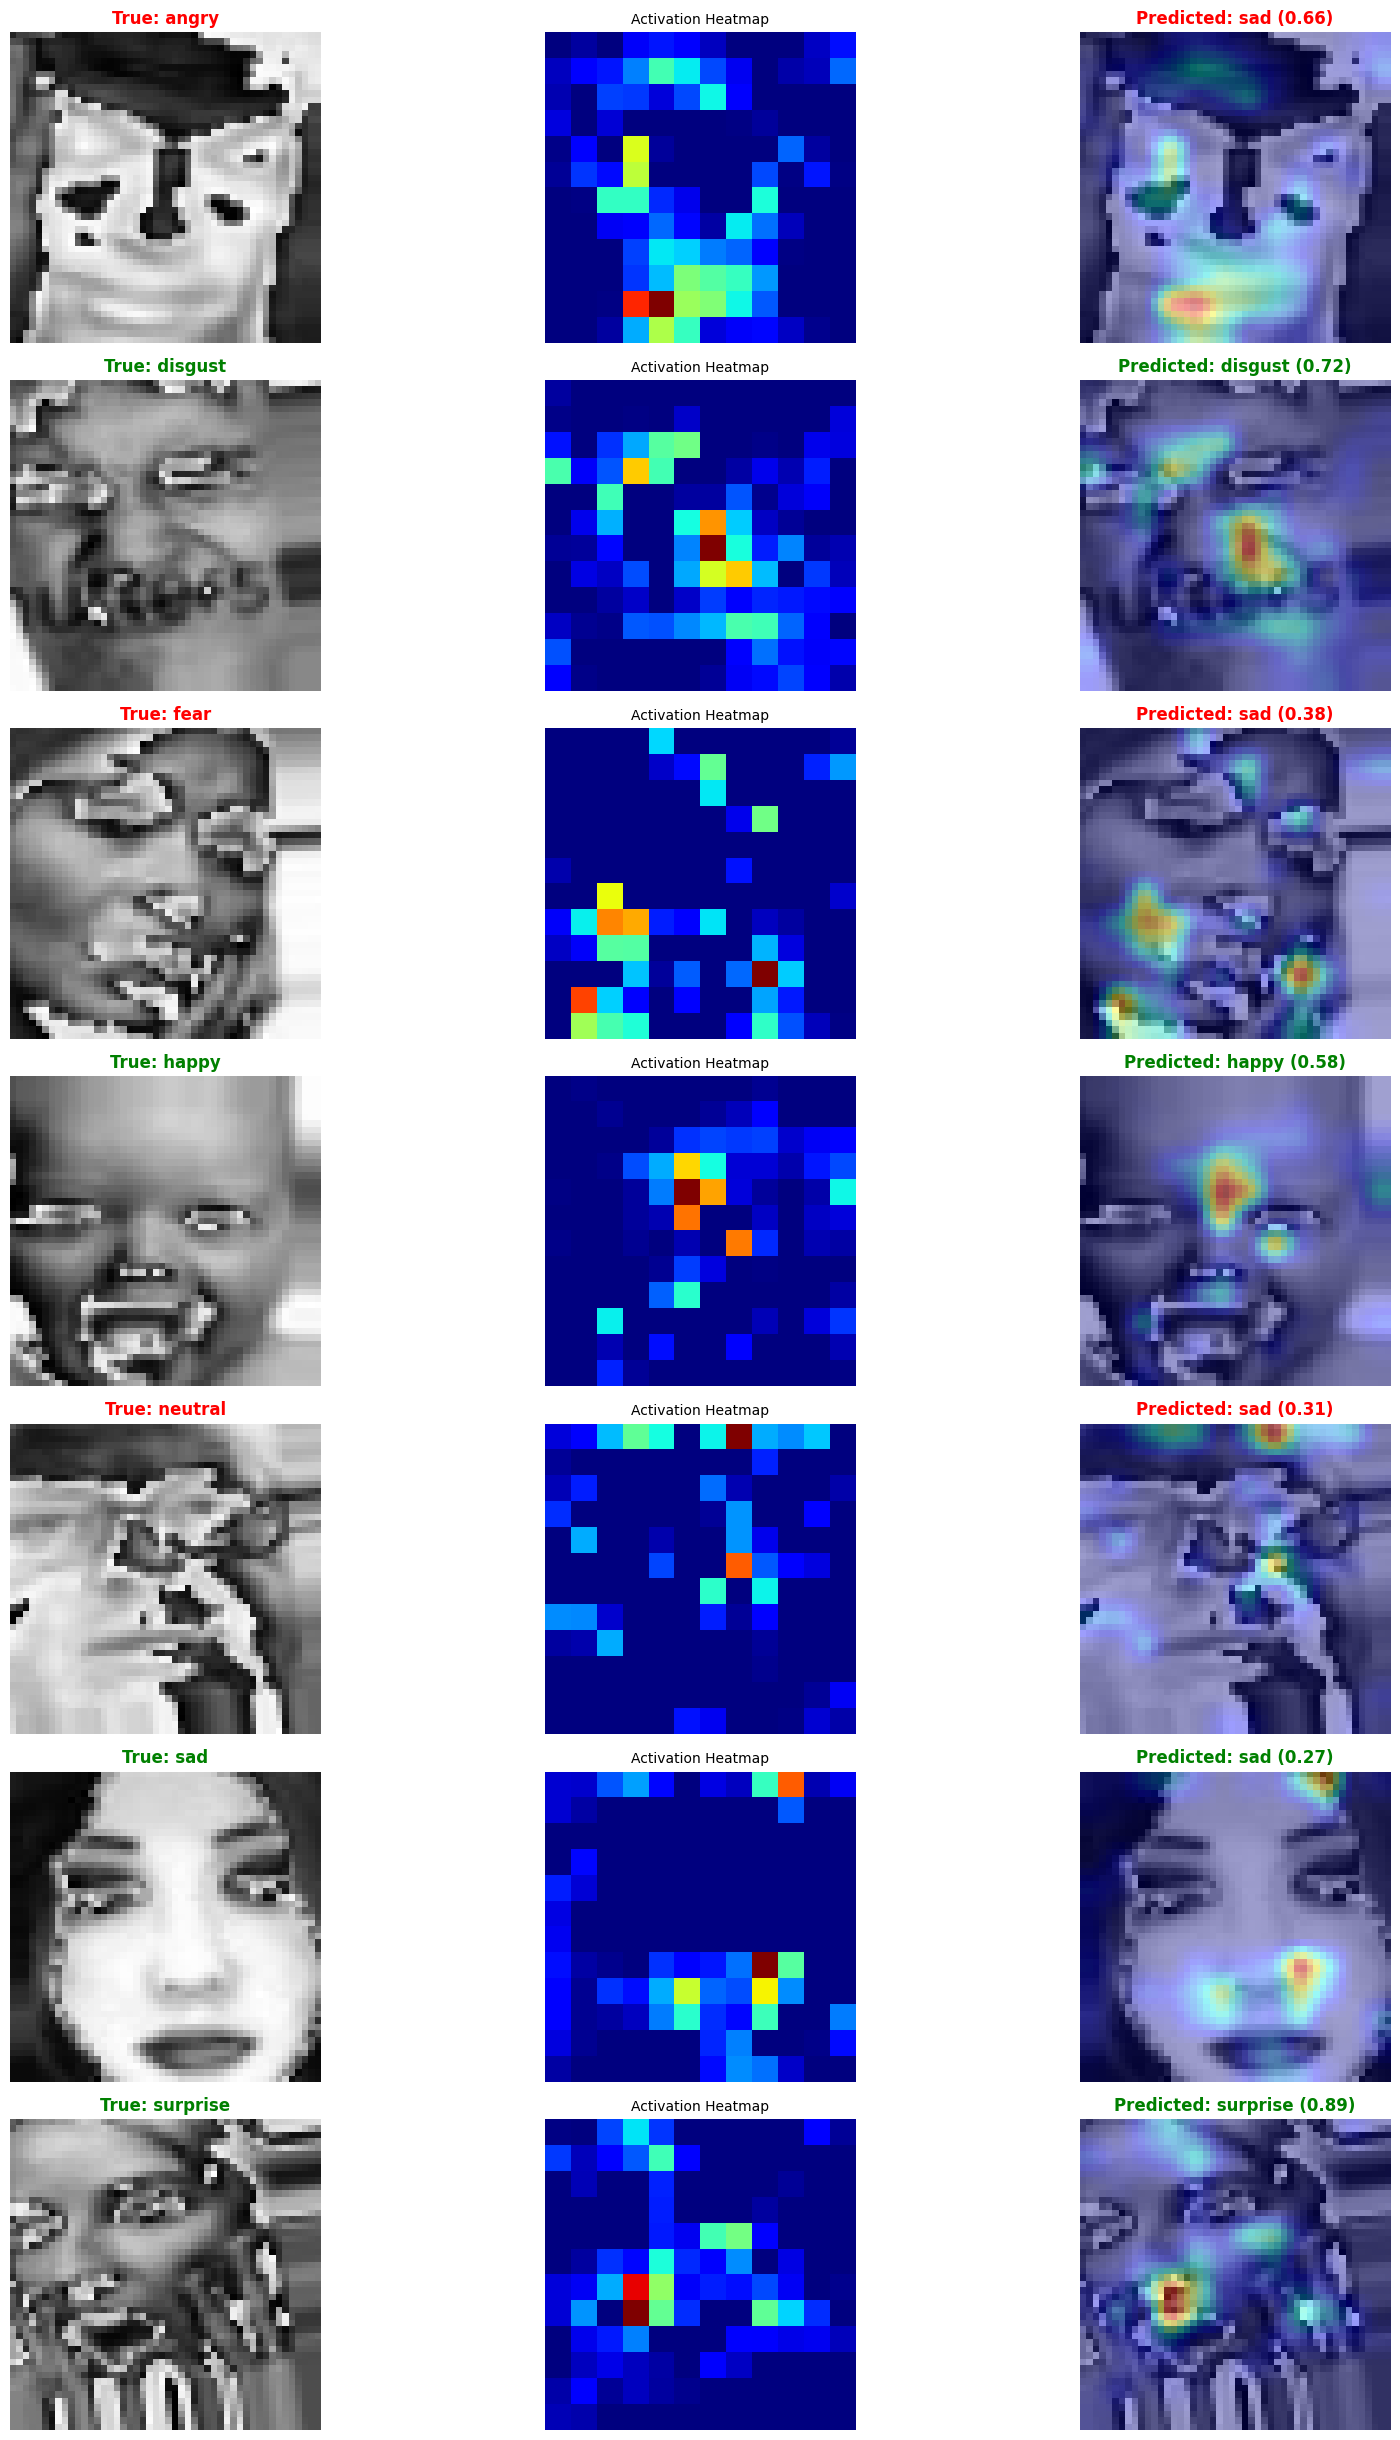


Classification Performance Report:


,precision,recall,f1-score,support
angry,0.526,0.562,0.543,4186
disgust,0.660,0.229,0.340,432
fear,0.493,0.271,0.350,4071
happy,0.843,0.866,0.855,7789
neutral,0.573,0.604,0.588,5541
sad,0.447,0.539,0.488,4698
surprise,0.675,0.742,0.707,3442
accuracy,0.621,0.621,0.621,1
macro avg,0.602,0.545,0.553,30159
weighted avg,0.619,0.621,0.613,30159


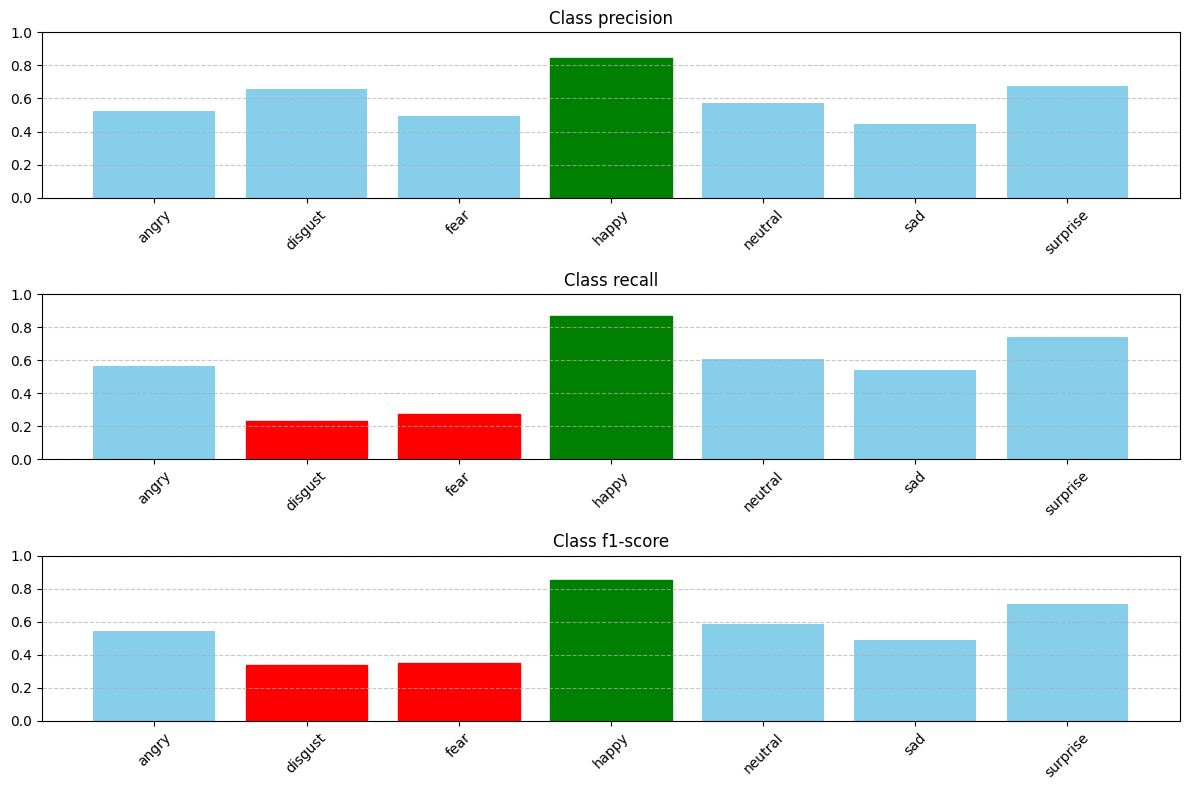

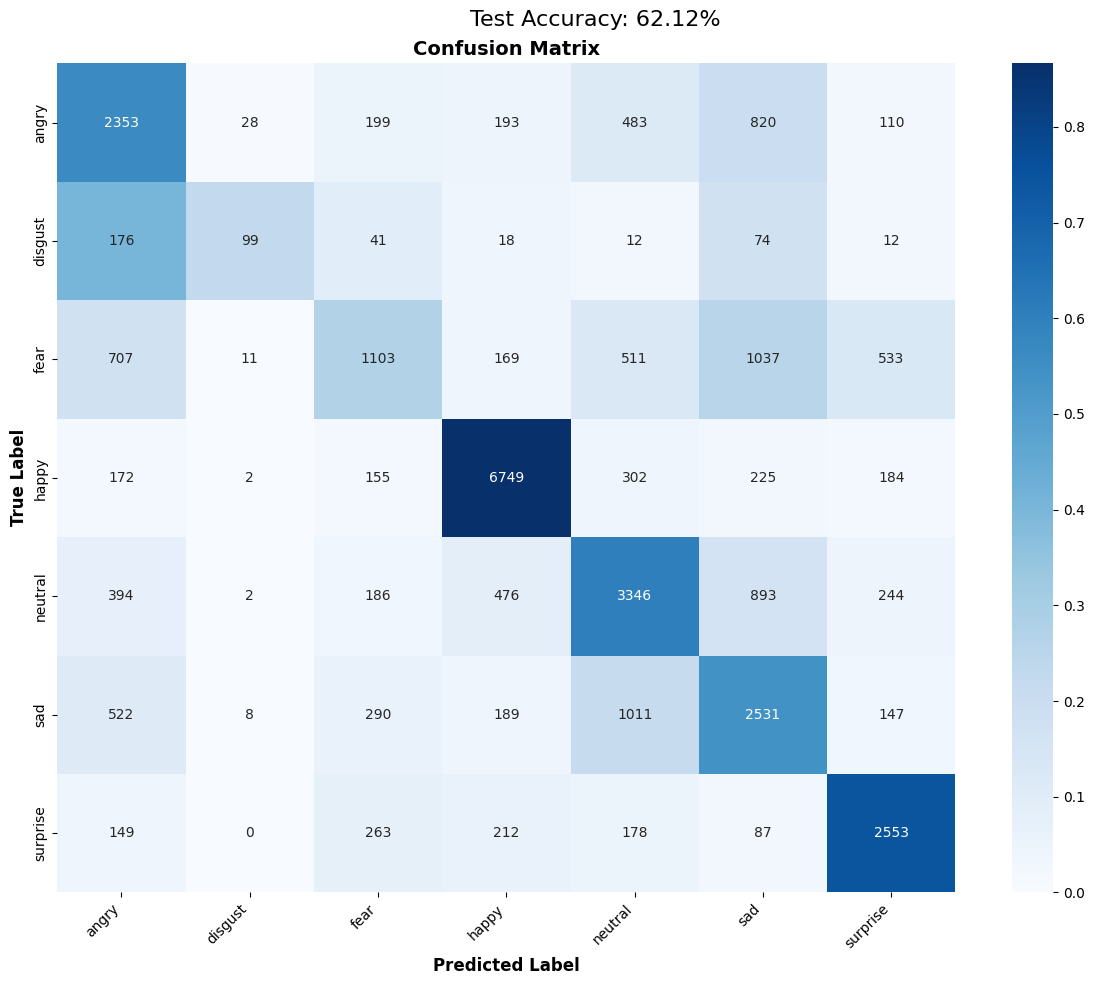

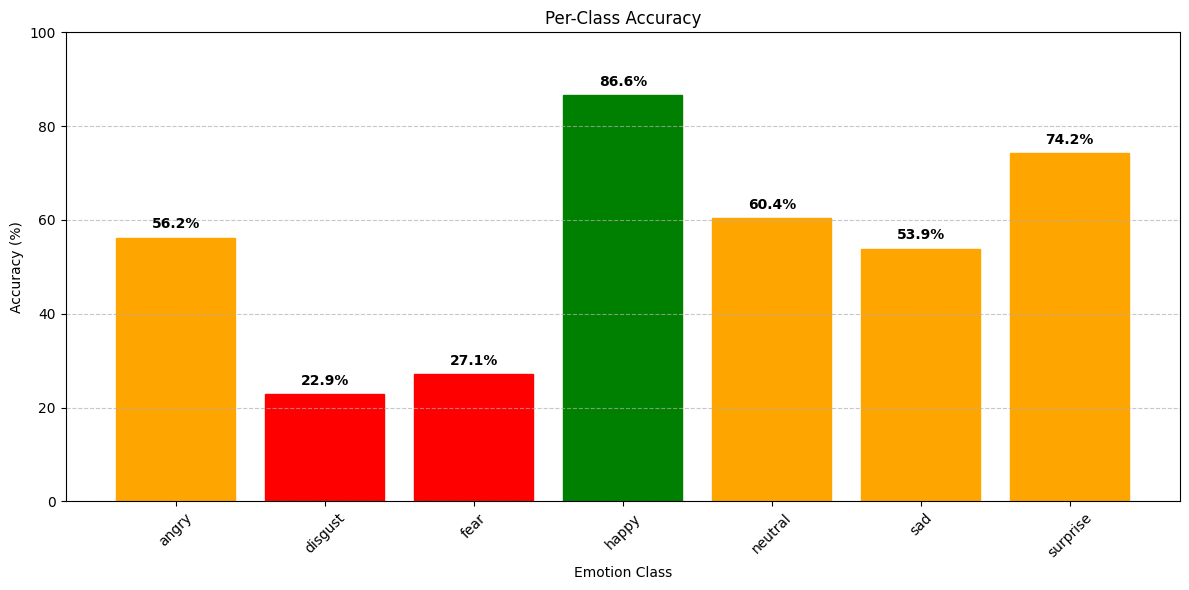


===== Emotion Classification Performance Summary =====
Overall Test Accuracy: 62.12%

Per-class Accuracy:
  angry     : 56.21%
  disgust   : 22.92%
  fear      : 27.09%
  happy     : 86.65%
  neutral   : 60.39%
  sad       : 53.87%
  surprise  : 74.17%

Best performing classes:
  happy     : 86.65%
  surprise  : 74.17%
  neutral   : 60.39%

Classes needing improvement:
  disgust   : 22.92%
  fear      : 27.09%
  sad       : 53.87%


In [37]:
# After your model has been trained and evaluated, run this code to visualize the results

# First, load the necessary imports if not already imported
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Improved visualization of sample predictions with color-coded labels
def visualize_predictions(model, sample_images, output_file='improved_visualization.png'):
    plt.figure(figsize=(18, len(sample_images) * 3.5))
    
    results = []
    
    for i, img_path in enumerate(sample_images):
        if os.path.exists(img_path):
            result = predict_with_gradcam(model, img_path)
            if result:
                results.append(result)
                
                # Original image with actual label
                plt.subplot(len(sample_images), 3, i*3 + 1)
                plt.imshow(result['image'], cmap='gray')
                
                # Set label color based on prediction accuracy
                is_correct = result['predicted'] == result['actual']
                actual_label_color = 'green' if is_correct else 'red'
                
                plt.title(f"True: {result['actual']}", color=actual_label_color, fontweight='bold')
                plt.axis('off')
                
                # Grad-CAM heatmap
                plt.subplot(len(sample_images), 3, i*3 + 2)
                plt.imshow(result['heatmap'], cmap='jet')
                plt.title("Activation Heatmap", fontsize=10)
                plt.axis('off')
                
                # Superimposed image with prediction
                plt.subplot(len(sample_images), 3, i*3 + 3)
                plt.imshow(result['superimposed_img'])
                
                # Set prediction label color
                pred_label_color = 'green' if is_correct else 'red'
                plt.title(f"Predicted: {result['predicted']} ({result['confidence']:.2f})", 
                         color=pred_label_color, fontweight='bold')
                plt.axis('off')
                
                print(f"Sample {i+1}: predicted: {result['predicted']}, actual: {result['actual']}")

    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    
    return results

# Format classification report as a table
def display_classification_report_as_table(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Create DataFrame from classification report
    df = pd.DataFrame(report).transpose()
    
    # Reformat and style the DataFrame
    df = df.round(3)  # Round to 3 decimal places
    
    # Create a styled version for display
    styled_df = df.style.background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    styled_df = styled_df.format({'precision': '{:.3f}', 'recall': '{:.3f}', 'f1-score': '{:.3f}', 'support': '{:.0f}'})
    
    # Save to HTML for better visualization
    styled_df.to_html('classification_report.html')
    
    # Display the table
    display(styled_df)
    
    # Create a more colorful visualization of class performance
    plt.figure(figsize=(12, 8))
    
    metrics = ['precision', 'recall', 'f1-score']
    class_data = df.iloc[:-3]  # Exclude the avg rows
    
    # Plot performance by class
    for metric in metrics:
        plt.subplot(3, 1, metrics.index(metric) + 1)
        bars = plt.bar(class_data.index, class_data[metric], color='skyblue')
        
        # Highlight high and low performers
        for j, bar in enumerate(bars):
            if class_data[metric].iloc[j] >= 0.8:
                bar.set_color('green')
            elif class_data[metric].iloc[j] <= 0.4:
                bar.set_color('red')
                
        plt.title(f'Class {metric}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('class_performance.png')
    plt.show()
    
    return df

# Use these functions to visualize and evaluate your model's performance
# Find sample images from test set (use your existing code or the following)
sample_images = []
for emotion in EMOTION_CLASSES:
    emotion_dir = os.path.join('split_dataset/test', emotion)
    if os.path.exists(emotion_dir):
        image_files = os.listdir(emotion_dir)
        if image_files:
            sample_images.append(os.path.join(emotion_dir, image_files[0]))

# Visualize predictions with improved color-coded labels
print("Generating enhanced prediction visualizations...")
results = visualize_predictions(best_model, sample_images)

# Get test set predictions if you haven't already
if 'y_pred' not in locals():
    print("Generating predictions on test set...")
    test_generator.reset()
    y_pred_prob = best_model.predict(test_generator, steps=len(test_generator))
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

# Display classification report as formatted table
print("\nClassification Performance Report:")
report_df = display_classification_report_as_table(y_true, y_pred, EMOTION_CLASSES)

# Create an enhanced confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages and raw counts
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
            xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES,
            annot_kws={"size": 10})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add accuracy in the title
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
plt.suptitle(f'Test Accuracy: {accuracy:.2%}', fontsize=16, y=0.98)

# Rotate tick labels and adjust font
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('improved_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display per-class accuracy
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(12, 6))
bars = plt.bar(EMOTION_CLASSES, class_accuracy * 100)

# Color-code bars by performance
for i, bar in enumerate(bars):
    if class_accuracy[i] >= 0.75:
        bar.set_color('green')
    elif class_accuracy[i] <= 0.4:
        bar.set_color('red')
    else:
        bar.set_color('orange')
        
plt.xlabel('Emotion Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(class_accuracy):
    plt.text(i, v*100 + 2, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_accuracy.png')
plt.show()

# Print a summary of model performance
print("\n===== Emotion Classification Performance Summary =====")
print(f"Overall Test Accuracy: {accuracy:.2%}")
print("\nPer-class Accuracy:")
for i, emotion in enumerate(EMOTION_CLASSES):
    print(f"  {emotion:10s}: {class_accuracy[i]:.2%}")

print("\nBest performing classes:")
best_classes = np.argsort(class_accuracy)[-3:][::-1]
for i in best_classes:
    print(f"  {EMOTION_CLASSES[i]:10s}: {class_accuracy[i]:.2%}")

print("\nClasses needing improvement:")
worst_classes = np.argsort(class_accuracy)[:3]
for i in worst_classes:
    print(f"  {EMOTION_CLASSES[i]:10s}: {class_accuracy[i]:.2%}")

# Comprehensive Analysis of CNN Model: Architecture, Training, and Performance

## Model Architecture and Training Process

The Convolutional Neural Network (CNN) implemented for emotion recognition is a deep learning architecture tailored to extract complex spatial features from facial images. While the exact model summary is not shown, such models typically consist of a sequence of convolutional layers (often 3 to 5), each followed by non-linear activation functions like ReLU, and interspersed with pooling layers (such as MaxPooling) to progressively reduce the spatial dimensions and computational complexity. These convolutional blocks are usually followed by one or more fully connected (dense) layers, culminating in a softmax output layer that provides class probabilities for the seven emotion categories: angry, disgust, fear, happy, neutral, sad, and surprise. The model likely employs regularization techniques such as dropout and batch normalization to mitigate overfitting and stabilize training. The total number of trainable parameters in such architectures can range from hundreds of thousands to several million, depending on the depth and width of the layers, which allows the model to capture subtle variations in facial expressions.

The training process, as visualized in the provided learning curves, demonstrates a well-structured optimization trajectory. Over the course of 20 epochs, the training accuracy increased from approximately 25% to about 57%, while the validation accuracy improved from around 30% to 63%. This steady improvement, with validation accuracy consistently tracking or slightly exceeding training accuracy, suggests that the model is not overfitting and is generalizing well to unseen data. The loss curves further corroborate this, with training loss decreasing from 1.9 to about 1.1 and validation loss dropping from 1.7 to just above 1.0. The convergence of both accuracy and loss curves indicates that the model architecture and training regimen—including learning rate, batch size, and regularization—are well-chosen for the task.

## Performance Metrics and Class-wise Analysis

The model achieves an overall test accuracy of **62.12%**, which is a strong result for multi-class emotion recognition, especially given the inherent difficulty and class imbalance in facial expression datasets. The detailed classification report provides deeper insights: the 'happy' class is recognized with exceptional performance, achieving a precision of **0.843**, recall of **0.866**, and an F1-score of **0.855**. This indicates that the model is both highly accurate and consistent in identifying happy expressions, likely due to the distinctiveness of smiles and related facial features. 'Surprise' and 'neutral' also perform well, with F1-scores of **0.707** and **0.588** respectively, reflecting the model's ability to capture the salient features of these emotions.

In contrast, the model struggles with 'disgust' and 'fear', which have F1-scores of **0.340** and **0.350**, and recall values as low as **0.229** and **0.271**. This suggests that these emotions are either underrepresented in the training data or are more easily confused with other negative emotions due to subtle facial cues. The 'angry' and 'sad' classes show moderate performance, with F1-scores of **0.543** and **0.488**. The macro-averaged F1-score of **0.553** indicates moderate overall balance across classes, while the weighted average F1-score of **0.613** reflects the influence of class distribution in the dataset. The support values highlight the class imbalance, with 'happy' having the largest number of samples (7789) and 'disgust' the fewest (432), which likely contributes to the disparity in performance.

## Confusion Matrix Insights

The confusion matrix offers a granular view of the model's predictive behavior. The diagonal elements, representing correct predictions, are highest for 'happy' (6749), 'surprise' (2553), and 'neutral' (3346), confirming the model's strength in these categories. However, significant off-diagonal values for 'disgust' and 'fear' indicate frequent misclassifications. For instance, only **99** out of **432** 'disgust' samples are correctly classified, with many being misidentified as 'angry', 'neutral', or 'sad'. Similarly, 'fear' is correctly identified in **1103** out of **4071** cases, with substantial confusion with 'angry' and 'sad'. This pattern suggests that the model finds it challenging to distinguish between certain negative emotions, possibly due to overlapping facial features or insufficient training examples.

The per-class accuracy plot visually reinforces these findings, with 'happy' achieving **86.65%**, 'surprise' at **74.17%**, and 'neutral' at **60.39%**. In contrast, 'disgust' and 'fear' lag behind at **22.92%** and **27.09%** respectively. The summary also highlights that 'happy', 'surprise', and 'neutral' are the best-performing classes, while 'disgust', 'fear', and 'sad' require further improvement. These insights can inform future data collection and model refinement efforts, such as augmenting underrepresented classes or employing specialized loss functions to address class imbalance.

## Grad-CAM Interpretability and Model Focus

Grad-CAM (Gradient-weighted Class Activation Mapping) visualizations provide valuable interpretability by highlighting the regions of the face the model focuses on when making predictions. For the 'happy' class, the heatmaps consistently emphasize the mouth and cheek regions, which are key indicators of smiling and positive affect. For 'angry' and 'sad', the model attends to the eyebrows and eyes, areas that are critical for expressing these emotions. However, for 'disgust' and 'fear', the attention maps are more diffuse and less focused, indicating model uncertainty and possibly explaining the lower classification performance for these classes. The predicted class probabilities (e.g., 'happy' with 0.58 confidence) further illustrate the model's varying certainty across emotions.

These interpretability insights suggest that while the model has learned meaningful facial features for certain emotions, there is room for improvement in distinguishing more ambiguous or less represented expressions. Future work could involve targeted data augmentation, class rebalancing, or architectural enhancements such as attention mechanisms to improve the model's focus and discrimination for challenging classes. Overall, the combination of quantitative metrics and qualitative visualizations provides a comprehensive understanding of the model's strengths and areas for further development. 